In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

import warnings
warnings.filterwarnings("ignore")


In [2]:
DATE_SPLIT_TRAIN_VALID = "2020-10-31"  #"2020-04-30" # "2020-10-31" 
DATE_SPLIT_PAST_FUTURE= '2021-04-30'

# Calculate the difference in months
date_diff_months = (pd.to_datetime(DATE_SPLIT_PAST_FUTURE).year - pd.to_datetime(DATE_SPLIT_TRAIN_VALID).year) * 12\
    + (pd.to_datetime(DATE_SPLIT_PAST_FUTURE).month - pd.to_datetime(DATE_SPLIT_TRAIN_VALID).month)

date_diff_months

6

In [3]:
def get_date_int(df, column):
   year = df[column].dt.year
   month = df[column].dt.month
   return year, month

In [4]:
def get_months_till_present(df,date_year,date_month,today_date):
    
    df=df.copy()
    
    year_today, month_today = int(today_date[:4]), int(today_date[5:7])
    
    df['months_till_present'] = 12*(year_today - df[date_year]) + (month_today -  df[date_month])
    
    return df

In [5]:
df = pd.read_csv('df_actuals.csv',parse_dates=[0,1])
print(f"Shape: {df.shape}\n\ndtypes:\n{df.dtypes}\n")
df.head()

Shape: (3654, 18)

dtypes:
Date                             datetime64[ns]
Intake Month                     datetime64[ns]
Country                                  object
Product                                  object
Net Customers                             int64
months_since_acquisition                  int64
churn_customers                         float64
Date_month                                int64
Date_year                                 int64
Cohort_month                              int64
Cohort_year                               int64
Cohort_size                               int64
Cohort_name                              object
retention_rate                          float64
diff_retention_rate                     float64
retention_rate_last                     float64
months_since_acquisition_last             int64
Type                                     object
dtype: object



,Date,Intake Month,Country,Product,Net Customers,months_since_acquisition,churn_customers,Date_month,Date_year,Cohort_month,Cohort_year,Cohort_size,Cohort_name,retention_rate,diff_retention_rate,retention_rate_last,months_since_acquisition_last,Type
0,2019-01-31,2019-01-31,US,A,110,0,0.0,1,2019,1,2019,110,Jan-19,100.000000,0.000000,51.818182,27,actual
1,2019-02-28,2019-01-31,US,A,88,1,22.0,2,2019,1,2019,110,Jan-19,80.000000,-20.000000,51.818182,27,actual
2,2019-03-31,2019-01-31,US,A,83,2,5.0,3,2019,1,2019,110,Jan-19,75.454545,-4.545455,51.818182,27,actual
3,2019-04-30,2019-01-31,US,A,77,3,6.0,4,2019,1,2019,110,Jan-19,70.000000,-5.454545,51.818182,27,actual
4,2019-05-31,2019-01-31,US,A,75,4,2.0,5,2019,1,2019,110,Jan-19,68.181818,-1.818182,51.818182,27,actual


In [6]:
df['retention_rate'] = df['retention_rate'].fillna(100)
df['diff_retention_rate'] = df['diff_retention_rate'].fillna(0)

In [7]:
lags=12

for i in range(1, lags+1):
    lag_column = f'lag_{i}_retention_rate'  # Name of the lagged column
    df[lag_column] = df.groupby(['Product','Country','Intake Month'])['retention_rate'].shift(i).fillna(100)
df

,Date,Intake Month,Country,Product,Net Customers,months_since_acquisition,churn_customers,Date_month,Date_year,Cohort_month,...,lag_3_retention_rate,lag_4_retention_rate,lag_5_retention_rate,lag_6_retention_rate,lag_7_retention_rate,lag_8_retention_rate,lag_9_retention_rate,lag_10_retention_rate,lag_11_retention_rate,lag_12_retention_rate
0,2019-01-31,2019-01-31,US,A,110,0,0.0,1,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,2019-02-28,2019-01-31,US,A,88,1,22.0,2,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,2019-03-31,2019-01-31,US,A,83,2,5.0,3,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,2019-04-30,2019-01-31,US,A,77,3,6.0,4,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,2019-05-31,2019-01-31,US,A,75,4,2.0,5,2019,1,...,80.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2021-03-31,2021-02-28,GB,C,47,1,13.0,3,2021,2,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3650,2021-04-30,2021-02-28,GB,C,44,2,3.0,4,2021,2,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3651,2021-03-31,2021-03-31,GB,C,61,0,0.0,3,2021,3,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3652,2021-04-30,2021-03-31,GB,C,44,1,17.0,4,2021,3,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


## Forecasting via ML

##### The trick here is to train a model to predict the delta retention rate 'diff_retention_rate' (instead of retention rate directly)
###### By detrending the retention rates, a tree-based model (like Random Forest) will be able to detect the patterns in the data better (tree based models are well known for for not being able to model trends or extrapolate but very good for detecting interactions, that's why we differentiate the retention rates)
###### Once we predict the 'diff_retention_rate' for each Prod x Country x Cohort x Date, we calculate the 'retention rate'
###### Lastly, we retention rate and Cohort size, we calculate the Net Customers retained

### Feature engineering for ML

get "months till present" = how recent is the cohort

In [8]:
df = get_months_till_present(df,'Cohort_year','Cohort_month',DATE_SPLIT_PAST_FUTURE)

df.head(5)

,Date,Intake Month,Country,Product,Net Customers,months_since_acquisition,churn_customers,Date_month,Date_year,Cohort_month,...,lag_4_retention_rate,lag_5_retention_rate,lag_6_retention_rate,lag_7_retention_rate,lag_8_retention_rate,lag_9_retention_rate,lag_10_retention_rate,lag_11_retention_rate,lag_12_retention_rate,months_till_present
0,2019-01-31,2019-01-31,US,A,110,0,0.0,1,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,27
1,2019-02-28,2019-01-31,US,A,88,1,22.0,2,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,27
2,2019-03-31,2019-01-31,US,A,83,2,5.0,3,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,27
3,2019-04-30,2019-01-31,US,A,77,3,6.0,4,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,27
4,2019-05-31,2019-01-31,US,A,75,4,2.0,5,2019,1,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,27


Generate lags for the target value "diff_retention_rates"

In [9]:
lags = 12  # Number of lags to generate

df = df.sort_values(by=['Product','Country','Intake Month','Date'],ascending=True)

for i in range(1, lags+1):
    lag_column = f'lag_{i}_diff_rr'  # Name of the lagged column
    df[lag_column] = df.groupby(['Product','Country','Intake Month'])['diff_retention_rate'].shift(i).fillna(0)

df

,Date,Intake Month,Country,Product,Net Customers,months_since_acquisition,churn_customers,Date_month,Date_year,Cohort_month,...,lag_3_diff_rr,lag_4_diff_rr,lag_5_diff_rr,lag_6_diff_rr,lag_7_diff_rr,lag_8_diff_rr,lag_9_diff_rr,lag_10_diff_rr,lag_11_diff_rr,lag_12_diff_rr
1218,2019-01-31,2019-01-31,CA,A,17,0,0.0,1,2019,1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1219,2019-02-28,2019-01-31,CA,A,13,1,4.0,2,2019,1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1220,2019-03-31,2019-01-31,CA,A,12,2,1.0,3,2019,1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1221,2019-04-30,2019-01-31,CA,A,12,3,0.0,4,2019,1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1222,2019-05-31,2019-01-31,CA,A,11,4,1.0,5,2019,1,...,-23.529412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,2021-03-31,2021-02-28,US,C,45,1,18.0,3,2021,2,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1215,2021-04-30,2021-02-28,US,C,42,2,3.0,4,2021,2,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1189,2021-03-31,2021-03-31,US,C,63,0,0.0,3,2021,3,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1216,2021-04-30,2021-03-31,US,C,49,1,14.0,4,2021,3,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# df.to_csv('lags_test.csv',index=False)

In [11]:
cat_cols = ['Country','Product']

num_cols = ['months_since_acquisition'
            ,'Date_month'
            ,'Date_year'
            ,'Cohort_month'
            ,'Cohort_year'
            ,'months_till_present']

target = 'diff_retention_rate'
            
# num_cols = ['months_since_acquisition'
#             ,'Date_month'
#             ,'Date_year'
#             ,'Cohort_month'
#             ,'Cohort_year'
#             ,'months_till_present'
#             ,'lag_1_diff_rr'
#             ,'lag_2_diff_rr'
#             ,'lag_3_diff_rr'
#             ,'lag_4_diff_rr'
#             ,'lag_5_diff_rr'
#             ,'lag_6_diff_rr'
#             ,'lag_7_diff_rr'
#             ,'lag_8_diff_rr'
#             ,'lag_9_diff_rr'
#             ,'lag_10_diff_rr'
#             ,'lag_11_diff_rr'
#             ,'lag_12_diff_rr']



### Cross-validation: split between "train" and "validation

To assess expected model performance

Note: because it is a time series problem, we should use a time based split (and not, for ex, a random cv split)

In [12]:
df_train = df.loc[(df['Date']<=DATE_SPLIT_TRAIN_VALID)]
df_valid = df.loc[(df['Date']>DATE_SPLIT_TRAIN_VALID)]

In [13]:
df_valid.shape

(1377, 43)

In [14]:
SEED = 42 #for RF

model = RandomForestRegressor(random_state=SEED,n_jobs=-1)
# model = CatBoostRegressor(random_state=SEED,n_estimators=N_ESTIMATORS)
# model = LGBMRegressor(random_state=SEED)


# Separate features (X) and target variable (y)
X_train = df_train[num_cols + cat_cols]
X_valid = df_valid[num_cols + cat_cols]

# Fit and transform the categorical columns using LabelEncoder
for col in cat_cols:
    
    le = LabelEncoder()
    le.fit(df_train[col])
    X_train[col] = le.transform(df_train[col])
    X_valid[col] = le.transform(df_valid[col])

y_train = df_train[target]
y_valid = df_valid[target]

# Fit the pipeline on the data
model.fit(X_train, y_train)

# Use the fitted pipeline for predictions
df_valid['pred_diff_retention_rates'] = model.predict(X_valid)


In [15]:
df_valid['retention_rate_last'] = df_valid.groupby(['Product','Country','Intake Month'])['lag_1_retention_rate'].transform('max')
df_valid['cum_pred_retention_rate'] = df_valid.groupby(['Product','Country','Intake Month'])['pred_diff_retention_rates'].cumsum()

df_valid['forecast_retention_rates'] = df_valid['retention_rate_last'] + df_valid['cum_pred_retention_rate'] 

df_valid['forecast_net_customers'] = df_valid['forecast_retention_rates']/100 * df_valid['Cohort_size']
df_valid['forecast_net_customers'] = df_valid['forecast_net_customers'].fillna(0).round()
df_valid

,Date,Intake Month,Country,Product,Net Customers,months_since_acquisition,churn_customers,Date_month,Date_year,Cohort_month,...,lag_7_diff_rr,lag_8_diff_rr,lag_9_diff_rr,lag_10_diff_rr,lag_11_diff_rr,lag_12_diff_rr,pred_diff_retention_rates,cum_pred_retention_rate,forecast_retention_rates,forecast_net_customers
1240,2020-11-30,2019-01-31,CA,A,9,22,0.0,11,2020,1,...,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.045455,-0.045455,52.895722,9.0
1241,2020-12-31,2019-01-31,CA,A,9,23,0.0,12,2020,1,...,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.045455,-0.090909,52.850267,9.0
1242,2021-01-31,2019-01-31,CA,A,9,24,0.0,1,2021,1,...,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.739708,-0.830617,52.110560,9.0
1243,2021-02-28,2019-01-31,CA,A,9,25,0.0,2,2021,1,...,-5.882353,0.000000,0.0,0.0,0.0,0.0,-0.739708,-1.570325,51.370852,9.0
1244,2021-03-31,2019-01-31,CA,A,9,26,0.0,3,2021,1,...,0.000000,-5.882353,0.0,0.0,0.0,0.0,-0.970063,-2.540388,50.400789,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,2021-03-31,2021-02-28,US,C,45,1,18.0,3,2021,2,...,0.000000,0.000000,0.0,0.0,0.0,0.0,-25.363732,-25.363732,74.636268,47.0
1215,2021-04-30,2021-02-28,US,C,42,2,3.0,4,2021,2,...,0.000000,0.000000,0.0,0.0,0.0,0.0,-5.121430,-30.485161,69.514839,44.0
1189,2021-03-31,2021-03-31,US,C,63,0,0.0,3,2021,3,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,100.000000,63.0
1216,2021-04-30,2021-03-31,US,C,49,1,14.0,4,2021,3,...,0.000000,0.000000,0.0,0.0,0.0,0.0,-26.146129,-26.146129,73.853871,47.0


In [16]:
y_true = df_valid['Net Customers'].values
y_pred = df_valid['forecast_net_customers'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {np.round(mae,3)}, R2: {np.round(r2,3)}, RMSE: {np.round(rmse,3)}")

MAE: 1.071, R2: 0.997, RMSE: 2.358


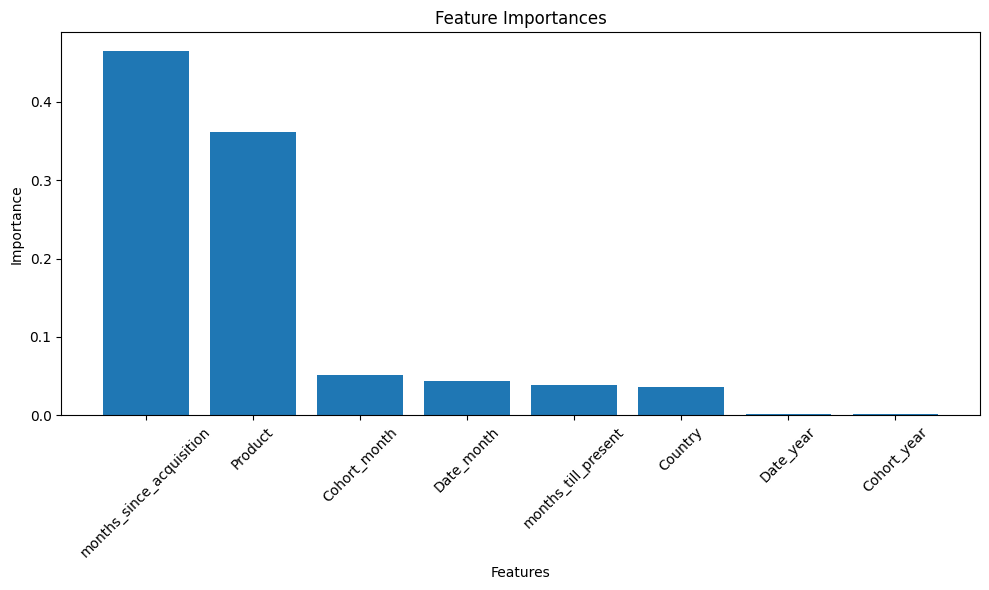

In [17]:
# Extract feature importances from the trained model
importances = model.feature_importances_

# Get the indices that would sort the importances array in descending order
sorted_indices = np.argsort(importances)[::-1]

# Get the top 10 feature importances and corresponding feature names
top_n = len(num_cols + cat_cols)
top_importances = importances[sorted_indices[:top_n]]
top_features = np.array(X_train.columns)[sorted_indices[:top_n]]

# Plotting the top feature importances in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), top_importances, tick_label=top_features)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

## Stacking

In [18]:
SEED = 42

# Instantiate the regression models
rf_model = RandomForestRegressor(random_state=SEED)
catboost_model = CatBoostRegressor(random_state=SEED,verbose=0)
lgbm_model = LGBMRegressor(random_state=SEED,verbose=0,force_row_wise=True)

meta_model = XGBRegressor(random_state=SEED) # LinearRegression()

# Create a list of models
models = [rf_model, catboost_model, lgbm_model]

# Fit each model on X_train
predictions = []
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    predictions.append(y_pred)

# Create the stacked dataset
stacked_data = np.vstack(predictions).T

# Fit the meta model with cross-validation
meta_predictions = cross_val_predict(meta_model, stacked_data, y_valid, cv=5)

df_valid['pred_diff_retention_rates'] = meta_predictions
df_valid['retention_rate_last'] = df_valid.groupby(['Product','Country','Intake Month'])['lag_1_retention_rate'].transform('max')
df_valid['cum_pred_retention_rate'] = df_valid.groupby(['Product','Country','Intake Month'])['pred_diff_retention_rates'].cumsum()
df_valid['forecast_retention_rates'] = df_valid['retention_rate_last'] + df_valid['cum_pred_retention_rate'] 
df_valid['forecast_net_customers'] = df_valid['forecast_retention_rates']/100 * df_valid['Cohort_size']
df_valid['forecast_net_customers'] = df_valid['forecast_net_customers'].fillna(0).round()

y_true = df_valid['Net Customers'].values
y_pred = df_valid['forecast_net_customers'].values
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {np.round(mae,3)}, R2: {np.round(r2,4)}, RMSE: {np.round(rmse,3)}")

MAE: 0.889, R2: 0.9978, RMSE: 2.032


### The stacking improves a little bit more the score (0.997)

In [19]:
df_valid.head(10)

,Date,Intake Month,Country,Product,Net Customers,months_since_acquisition,churn_customers,Date_month,Date_year,Cohort_month,...,lag_7_diff_rr,lag_8_diff_rr,lag_9_diff_rr,lag_10_diff_rr,lag_11_diff_rr,lag_12_diff_rr,pred_diff_retention_rates,cum_pred_retention_rate,forecast_retention_rates,forecast_net_customers
1240,2020-11-30,2019-01-31,CA,A,9,22,0.0,11,2020,1,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.087235,0.087235,53.028411,9.0
1241,2020-12-31,2019-01-31,CA,A,9,23,0.0,12,2020,1,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.041132,0.046103,52.987279,9.0
1242,2021-01-31,2019-01-31,CA,A,9,24,0.0,1,2021,1,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,-1.183854,-1.137751,51.803426,9.0
1243,2021-02-28,2019-01-31,CA,A,9,25,0.0,2,2021,1,...,-5.882353,0.000000,0.000000,0.0,0.0,0.0,-1.638950,-2.776700,50.164476,9.0
1244,2021-03-31,2019-01-31,CA,A,9,26,0.0,3,2021,1,...,0.000000,-5.882353,0.000000,0.0,0.0,0.0,-0.837982,-3.614683,49.326494,8.0
1245,2021-04-30,2019-01-31,CA,A,9,27,0.0,4,2021,1,...,0.000000,0.000000,-5.882353,0.0,0.0,0.0,-1.527519,-5.142202,47.798975,8.0
1267,2020-11-30,2019-02-28,CA,A,7,21,0.0,11,2020,2,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.024778,-0.024778,49.975222,7.0
1268,2020-12-31,2019-02-28,CA,A,7,22,0.0,12,2020,2,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.043402,-0.068180,49.931820,7.0
1269,2021-01-31,2019-02-28,CA,A,7,23,0.0,1,2021,2,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.634246,-0.702426,49.297574,7.0
1270,2021-02-28,2019-02-28,CA,A,7,24,0.0,2,2021,2,...,-7.142857,0.000000,0.000000,0.0,0.0,0.0,-0.690238,-1.392664,48.607336,7.0


### Let's forecast test dataset now

##### We read the same file from the 'baseline' notebook to have it as template, we just need to change predictions

In [43]:
df_forecast = pd.read_csv('df_forecast_baseline.csv',parse_dates=[0,1])
df_forecast.shape

(8748, 11)

In [44]:
df_forecast['Date_year'], df_forecast['Date_month'] = get_date_int(df_forecast, 'Date')

df_forecast['Cohort_year'], df_forecast['Cohort_month'] = get_date_int(df_forecast, 'Intake Month')

df_forecast = get_months_till_present(df_forecast,'Cohort_year','Cohort_month',DATE_SPLIT_PAST_FUTURE)

df_forecast

,Date,Intake Month,Product,Country,Cohort_type,Type,months_since_acquisition,Cohort_size,forecast_retention_rates,forecast_net_customers,Net Customers,Date_year,Date_month,Cohort_year,Cohort_month,months_till_present
0,2021-05-31,2019-01-31,A,CA,old,forecast,28,17,52.380952,9.0,NaN,2021,5,2019,1,27
1,2021-06-30,2019-01-31,A,CA,old,forecast,29,17,51.820728,9.0,NaN,2021,6,2019,1,27
2,2021-07-31,2019-01-31,A,CA,old,forecast,30,17,51.260504,9.0,NaN,2021,7,2019,1,27
3,2021-08-31,2019-01-31,A,CA,old,forecast,31,17,50.700280,9.0,NaN,2021,8,2019,1,27
4,2021-09-30,2019-01-31,A,CA,old,forecast,32,17,50.140056,9.0,NaN,2021,9,2019,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8743,2023-04-30,2023-04-30,B,CA,new,forecast,0,0,100.000000,0.0,NaN,2023,4,2023,4,-24
8744,2023-04-30,2023-04-30,B,GB,new,forecast,0,0,100.000000,0.0,NaN,2023,4,2023,4,-24
8745,2023-04-30,2023-04-30,C,US,new,forecast,0,75,100.000000,75.0,NaN,2023,4,2023,4,-24
8746,2023-04-30,2023-04-30,C,CA,new,forecast,0,12,100.000000,12.0,NaN,2023,4,2023,4,-24


#### Get last retention rate and months since acquisition

In [45]:
df_forecast['retention_rate_last'] = np.nan
df_forecast['months_since_acquisition_last'] = np.nan

for col in ['months_since_acquisition_last','retention_rate_last']:
    
    df_forecast[col] = df_forecast[col].fillna(
        df_forecast.merge(df[['Product'
                            ,'Country'
                            ,'Intake Month'
                            ,'months_since_acquisition_last'
                            ,'retention_rate_last']].drop_duplicates()
                        ,on=['Product', 'Country','Intake Month']
                        ,how='left')[f'{col}_y']
    )

df_forecast.loc[df_forecast['Cohort_type']=='new','retention_rate_last']=100
df_forecast.loc[df_forecast['Cohort_type']=='new','months_since_acquisition_last']=0

df_forecast

,Date,Intake Month,Product,Country,Cohort_type,Type,months_since_acquisition,Cohort_size,forecast_retention_rates,forecast_net_customers,Net Customers,Date_year,Date_month,Cohort_year,Cohort_month,months_till_present,retention_rate_last,months_since_acquisition_last
0,2021-05-31,2019-01-31,A,CA,old,forecast,28,17,52.380952,9.0,NaN,2021,5,2019,1,27,52.941176,27.0
1,2021-06-30,2019-01-31,A,CA,old,forecast,29,17,51.820728,9.0,NaN,2021,6,2019,1,27,52.941176,27.0
2,2021-07-31,2019-01-31,A,CA,old,forecast,30,17,51.260504,9.0,NaN,2021,7,2019,1,27,52.941176,27.0
3,2021-08-31,2019-01-31,A,CA,old,forecast,31,17,50.700280,9.0,NaN,2021,8,2019,1,27,52.941176,27.0
4,2021-09-30,2019-01-31,A,CA,old,forecast,32,17,50.140056,9.0,NaN,2021,9,2019,1,27,52.941176,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8743,2023-04-30,2023-04-30,B,CA,new,forecast,0,0,100.000000,0.0,NaN,2023,4,2023,4,-24,100.000000,0.0
8744,2023-04-30,2023-04-30,B,GB,new,forecast,0,0,100.000000,0.0,NaN,2023,4,2023,4,-24,100.000000,0.0
8745,2023-04-30,2023-04-30,C,US,new,forecast,0,75,100.000000,75.0,NaN,2023,4,2023,4,-24,100.000000,0.0
8746,2023-04-30,2023-04-30,C,CA,new,forecast,0,12,100.000000,12.0,NaN,2023,4,2023,4,-24,100.000000,0.0


In [46]:
SEED = 42 #for RF
# N_ESTIMATORS=1000

model = RandomForestRegressor(random_state=SEED,n_jobs=-1)
# model = CatBoostRegressor(random_state=SEED,n_estimators=N_ESTIMATORS)
# model = LGBMRegressor(random_state=SEED)


# Separate features (X) and target variable (y)
X_train = df[num_cols + cat_cols]
X_test = df_forecast[num_cols + cat_cols]

# Fit and transform the categorical columns using LabelEncoder
for col in cat_cols:
    
    le = LabelEncoder()
    le.fit(df_train[col])
    X_train[col] = le.transform(df[col])
    X_test[col] = le.transform(df_forecast[col])

y_train = df[target]

# Fit the pipeline on the data
model.fit(X_train, y_train)

# Use the fitted pipeline for predictions
df_forecast['pred_diff_retention_rates'] = model.predict(X_test)

In [47]:
df_forecast

,Date,Intake Month,Product,Country,Cohort_type,Type,months_since_acquisition,Cohort_size,forecast_retention_rates,forecast_net_customers,Net Customers,Date_year,Date_month,Cohort_year,Cohort_month,months_till_present,retention_rate_last,months_since_acquisition_last,pred_diff_retention_rates
0,2021-05-31,2019-01-31,A,CA,old,forecast,28,17,52.380952,9.0,NaN,2021,5,2019,1,27,52.941176,27.0,0.000000
1,2021-06-30,2019-01-31,A,CA,old,forecast,29,17,51.820728,9.0,NaN,2021,6,2019,1,27,52.941176,27.0,0.000000
2,2021-07-31,2019-01-31,A,CA,old,forecast,30,17,51.260504,9.0,NaN,2021,7,2019,1,27,52.941176,27.0,-0.978992
3,2021-08-31,2019-01-31,A,CA,old,forecast,31,17,50.700280,9.0,NaN,2021,8,2019,1,27,52.941176,27.0,-0.294118
4,2021-09-30,2019-01-31,A,CA,old,forecast,32,17,50.140056,9.0,NaN,2021,9,2019,1,27,52.941176,27.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8743,2023-04-30,2023-04-30,B,CA,new,forecast,0,0,100.000000,0.0,NaN,2023,4,2023,4,-24,100.000000,0.0,0.000000
8744,2023-04-30,2023-04-30,B,GB,new,forecast,0,0,100.000000,0.0,NaN,2023,4,2023,4,-24,100.000000,0.0,0.000000
8745,2023-04-30,2023-04-30,C,US,new,forecast,0,75,100.000000,75.0,NaN,2023,4,2023,4,-24,100.000000,0.0,0.000000
8746,2023-04-30,2023-04-30,C,CA,new,forecast,0,12,100.000000,12.0,NaN,2023,4,2023,4,-24,100.000000,0.0,0.000000


In [48]:
df_forecast['cum_pred_retention_rate'] = df_forecast.groupby(['Product','Country','Intake Month'])['pred_diff_retention_rates'].cumsum()
df_forecast['forecast_retention_rates'] = df_forecast['retention_rate_last'] + df_forecast['cum_pred_retention_rate'] 

df_forecast['forecast_net_customers'] = df_forecast['forecast_retention_rates']/100 * df_forecast['Cohort_size']
df_forecast['forecast_net_customers'] = df_forecast['forecast_net_customers'].fillna(0).round()

df_forecast

,Date,Intake Month,Product,Country,Cohort_type,Type,months_since_acquisition,Cohort_size,forecast_retention_rates,forecast_net_customers,Net Customers,Date_year,Date_month,Cohort_year,Cohort_month,months_till_present,retention_rate_last,months_since_acquisition_last,pred_diff_retention_rates,cum_pred_retention_rate
0,2021-05-31,2019-01-31,A,CA,old,forecast,28,17,52.941176,9.0,NaN,2021,5,2019,1,27,52.941176,27.0,0.000000,0.000000
1,2021-06-30,2019-01-31,A,CA,old,forecast,29,17,52.941176,9.0,NaN,2021,6,2019,1,27,52.941176,27.0,0.000000,0.000000
2,2021-07-31,2019-01-31,A,CA,old,forecast,30,17,51.962185,9.0,NaN,2021,7,2019,1,27,52.941176,27.0,-0.978992,-0.978992
3,2021-08-31,2019-01-31,A,CA,old,forecast,31,17,51.668067,9.0,NaN,2021,8,2019,1,27,52.941176,27.0,-0.294118,-1.273109
4,2021-09-30,2019-01-31,A,CA,old,forecast,32,17,51.668067,9.0,NaN,2021,9,2019,1,27,52.941176,27.0,0.000000,-1.273109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8743,2023-04-30,2023-04-30,B,CA,new,forecast,0,0,100.000000,0.0,NaN,2023,4,2023,4,-24,100.000000,0.0,0.000000,0.000000
8744,2023-04-30,2023-04-30,B,GB,new,forecast,0,0,100.000000,0.0,NaN,2023,4,2023,4,-24,100.000000,0.0,0.000000,0.000000
8745,2023-04-30,2023-04-30,C,US,new,forecast,0,75,100.000000,75.0,NaN,2023,4,2023,4,-24,100.000000,0.0,0.000000,0.000000
8746,2023-04-30,2023-04-30,C,CA,new,forecast,0,12,100.000000,12.0,NaN,2023,4,2023,4,-24,100.000000,0.0,0.000000,0.000000


In [49]:
df_forecast.to_csv('df_forecast_random_forest.csv',index=False)

In [50]:
cols_actuals = ['Product','Country','Intake Month','Date','retention_rate','Type','Net Customers']
cols_forecast = ['Product','Country','Intake Month','Date','forecast_retention_rates','Type','forecast_net_customers']

df_all = pd.concat([df[cols_actuals]
            ,df_forecast[cols_forecast]
                            ]
                             ,axis=0)

df_all['retention_rate'] = np.where(df_all['retention_rate'].isnull(),df_all['forecast_retention_rates'],df_all['retention_rate'])
df_all['Net Customers'] = np.where(df_all['Net Customers'].isnull(),df_all['forecast_net_customers'],df_all['Net Customers'])

df_all = df_all.drop(['forecast_retention_rates','forecast_net_customers'],axis=1)
print(f"shape: {df_all.shape}")
df_all

shape: (12402, 7)


,Product,Country,Intake Month,Date,retention_rate,Type,Net Customers
1218,A,CA,2019-01-31,2019-01-31,100.000000,actual,17.0
1219,A,CA,2019-01-31,2019-02-28,76.470588,actual,13.0
1220,A,CA,2019-01-31,2019-03-31,70.588235,actual,12.0
1221,A,CA,2019-01-31,2019-04-30,70.588235,actual,12.0
1222,A,CA,2019-01-31,2019-05-31,64.705882,actual,11.0
...,...,...,...,...,...,...,...
8743,B,CA,2023-04-30,2023-04-30,100.000000,forecast,0.0
8744,B,GB,2023-04-30,2023-04-30,100.000000,forecast,0.0
8745,C,US,2023-04-30,2023-04-30,100.000000,forecast,75.0
8746,C,CA,2023-04-30,2023-04-30,100.000000,forecast,12.0


In [51]:
df_all.to_csv('df_all_net_customers_random_forest.csv',index=False)